In [34]:
# import packages
import matplotlib.pyplot as plt
from scipy.optimize import brentq
import numpy as np
from ar1_approx import addacooper
from numba import vectorize, jit, i8, f8, void
from fast import interp
#interp is a function I wrote that optimizes the speed of linearly interpolating a single value, as in exercise 3.

In [35]:
alpha_k = 0.297
alpha_l = 0.650
delta = 0.154
psi1 = 1.080
psi2 = 0.03
w = 0.700
r = 0.040
sigma_z = 0.213
mu = 0.000
rho = 0.7605
sizez = 9
betafirm = 1 / (1 + r)
VFtol = 1e-6
PF3tol = 1e-6
VFmaxiter = 3000

# Exercise 1 #

In [36]:
z_grid, pi = addacooper(sizez, mu, rho, sigma_z)
z_grid = np.exp(z_grid)

In [37]:
dens = 5
# put in bounds here for the capital stock space
#kstar = (((alpha_k / (1 / betafirm - 1 + delta))**(1 - alpha_l)) * ((alpha_l / w) ** alpha_l)) ** (1 - alpha_k - alpha_l)
#above is a possible correction for the value of kstar...
kstar = kstar = ((((1 / betafirm - 1 + delta) * ((w / alpha_l) **
                                         (alpha_l / (1 - alpha_l)))) /
         (alpha_k)) **
         ((1 - alpha_l) / (alpha_k + alpha_l - 1)))
kbar = 3*kstar
lb_k = 0.001
ub_k = kbar
krat = np.log(lb_k / ub_k)
numb = np.ceil(krat / np.log(1 - delta))
K = np.zeros(int(numb * dens))
# we'll create in a way where we pin down the upper bound - since
# the distance will be small near the lower bound, we'll miss that by little
for j in range(int(numb * dens)):
    K[j] = ub_k * (1 - delta) ** (j / dens)
k_grid = K[::-1]
sizek = k_grid.shape[0]

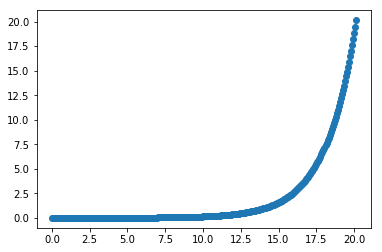

In [38]:
k_linear = np.linspace(lb_k, ub_k, num=sizek)
plt.scatter(k_linear, k_grid)
plt.show()

In [39]:
#profit grid
op_grid = np.empty((sizek, sizez))

for k in range(sizez):
    op_grid[:, k] = (1 - alpha_l) * ((alpha_l / w) ** (alpha_l / (1 - alpha_l))) * (z_grid[k] ** (1 / (1 - alpha_l))) * (k_grid ** (alpha_k / (1 - alpha_l)))

# firm cash flow, e
e1_grid = np.zeros((sizek, sizek, sizez))
for i in range(sizek):  # loop over k
    for j in range(sizek):  # loop over k'
        for k in range(sizez):  # loop over z
            e1_grid[i, j, k] = (op_grid[i, k] - k_grid[j] + ((1 - delta) * k_grid[i]) -
                            ((psi1 / 2) * ((k_grid[j] - ((1 - delta) * k_grid[i])) ** 2) / k_grid[i]))

In [40]:
V1 = np.zeros((sizek, sizez))  # initial guess at value function
Vmat = np.zeros((sizek, sizek, sizez))  # initialize Vmat matrix
VFiter = 1
VFdist = 7.0

In [41]:
@vectorize('f8(f8, f8)')
def prod(x, y):
    return x * y

@jit(void(i8, i8, f8, f8[:,:], f8[:,:], f8[:,:,:]))
def forloop1(sizek, sizez, betafirm, pi, V1, Vmat):
    for i in range(sizek):  # loop over k
        for j in range(sizek):  # loop over k'
            for k in range(sizez):  # loop over z
                Vmat[i, j, k] = e1_grid[i, j, k] + betafirm * np.sum(prod(pi[k, :], V1[j, :]))

VFiter = 1
while VFdist > VFtol and VFiter < VFmaxiter:
    TV1 = V1.copy()
    forloop1(sizek, sizez, betafirm, pi, V1, Vmat)
    V1 = Vmat.max(axis=1)  # apply max operator to Vmat
    PF1_indices = np.argmax(Vmat, axis=1)  # find the index of the optimal k'
    VFdist = (np.absolute(V1 - TV1)).max()  # check distance between value
    # function for this iteration and value function from past iteration
    VFiter += 1

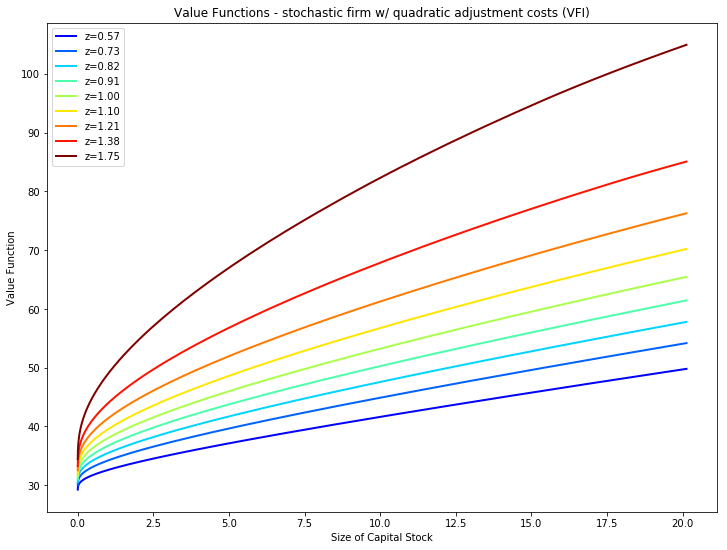

In [42]:
plt.subplots(figsize=(12, 9))
for k in range(sizez):
    lb = 'z='+format(z_grid[k],'.2f')
    plt.plot(k_grid, V1[:,k], color=plt.cm.jet((k+1)/sizez),lw=2,label=lb)
plt.xlabel('Size of Capital Stock')
plt.ylabel('Value Function')
plt.title('Value Functions - stochastic firm w/ quadratic adjustment costs (VFI)')
plt.legend(loc='best')
plt.show()

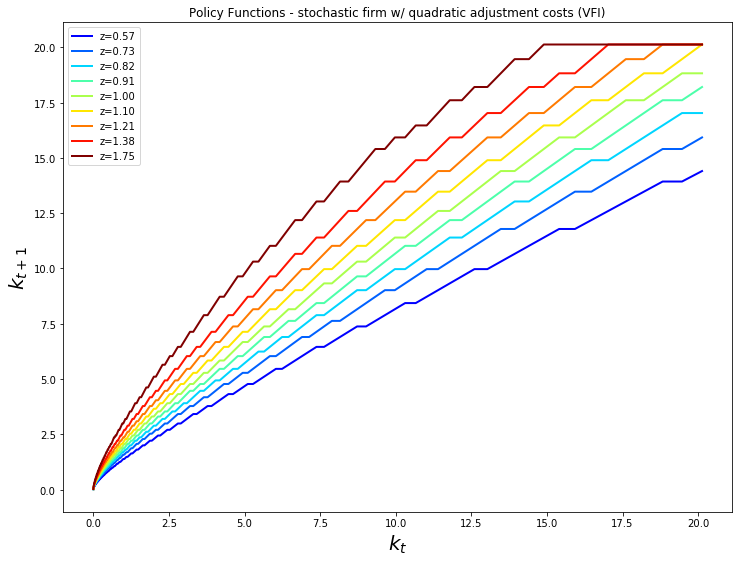

In [50]:
PF1 = np.array([[k_grid[PF1_indices[i, k]] for k in range(sizez)] for i in range(sizek)])
        
plt.subplots(figsize=(12, 9))
for k in range(sizez):
    lb = 'z='+format(z_grid[k],'.2f')
    plt.plot(k_grid, PF1[:,k], color=plt.cm.jet((k+1)/sizez),lw=2,label=lb)
plt.xlabel(r'$k_t$', fontsize=20)
plt.ylabel(r'$k_{t + 1}$', fontsize=20)
plt.title('Policy Functions - stochastic firm w/ quadratic adjustment costs (VFI)')
plt.legend(loc='best')
plt.show()

# Exercise 2 #

In [44]:
V2 = np.zeros((sizek, sizez))  # initial guess at value function
Vmat1 = np.zeros((sizek, sizek, sizez))  # initialize the first Vmat matrix
Vmat2 = np.zeros((sizek, sizez))  # initialize the second Vmat matrix
VFiter = 1
VFdist = 7.0

In [45]:
# firm cash flow, e1
e2_grid = np.empty((sizek, sizek, sizez))
for i in range(sizek):  # loop over k
    for j in range(sizek):  # loop over k'
        for k in range(sizez):  # loop over z
            e2_grid[i, j, k] = op_grid[i, k] - k_grid[j] + ((1 - delta) * k_grid[i]) - psi2 * k_grid[i]

In [46]:
@jit(void(i8, i8, i8, f8, f8[:,:], f8[:,:], f8[:,:], f8[:,:], f8[:,:], f8[:,:,:]))
def forloop2(sizek, sizez, dens, betafirm, e2_grid, op_grid, pi, V2, Vmat2, Vmat1):
    for i in range(sizek):  # loop over k
        for k in range(sizez):  # loop over z
            if (i - dens) < 0:
                Vmat2[i, k] = op_grid[i, k] + betafirm * np.sum(prod(pi[k, :], V2[i, :]))
            else:
                Vmat2[i, k] = op_grid[i, k] + betafirm * np.sum(prod(pi[k, :], V2[i - dens, :]))
            for j in range(sizek):  # loop over k'
                Vmat1[i, j, k] = e2_grid[i, j, k] + betafirm * np.sum(prod(pi[k, :], V2[j, :]))

while VFdist > VFtol and VFiter < VFmaxiter:
    TV2 = V2.copy()
    forloop2(sizek, sizez, dens, betafirm, e2_grid, op_grid, pi, V2, Vmat2, Vmat1)
    concat = np.array([Vmat1.max(axis=1), Vmat2])
    V2 = concat.max(axis=0)
    VFdist = (np.absolute(V2 - TV2)).max()  # check distance between value
    # function for this iteration and value function from past iteration
    VFiter += 1


choice = concat.argmax(axis=0)
PF2_indices = np.argmax(Vmat1, axis=1)
PF2 = np.zeros((sizek, sizez))

for i in range(sizek):  # loop over k
    for k in range(sizez):  # loop over z
        if choice[i, k] == 1:
            if (i - dens) < 0:
                PF2[i, k] = k_grid[i]
            else:
                PF2[i, k] = k_grid[i - dens]
        else:
            PF2[i, k] = k_grid[PF2_indices[i, k]]

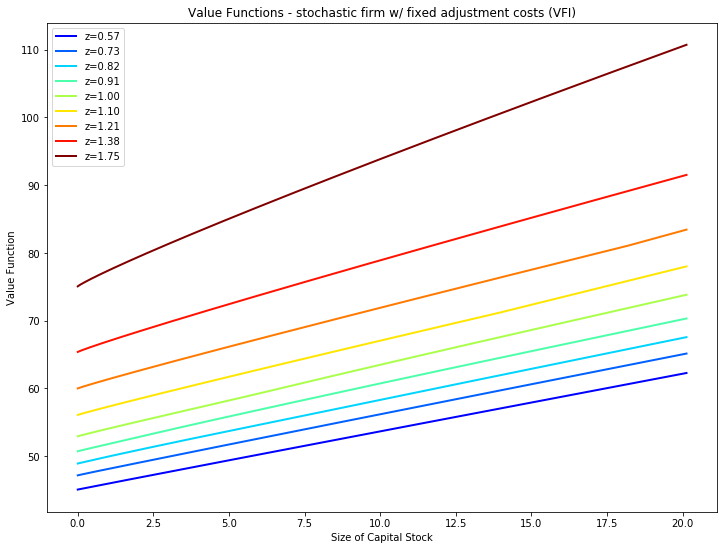

In [47]:
plt.subplots(figsize=(12, 9))
for k in range(sizez):
    lb = 'z='+format(z_grid[k],'.2f')
    plt.plot(k_grid, V2[:,k], color=plt.cm.jet((k+1)/sizez),lw=2,label=lb)
plt.xlabel('Size of Capital Stock')
plt.ylabel('Value Function')
plt.title('Value Functions - stochastic firm w/ fixed adjustment costs (VFI)')
plt.legend(loc='best')
plt.show()

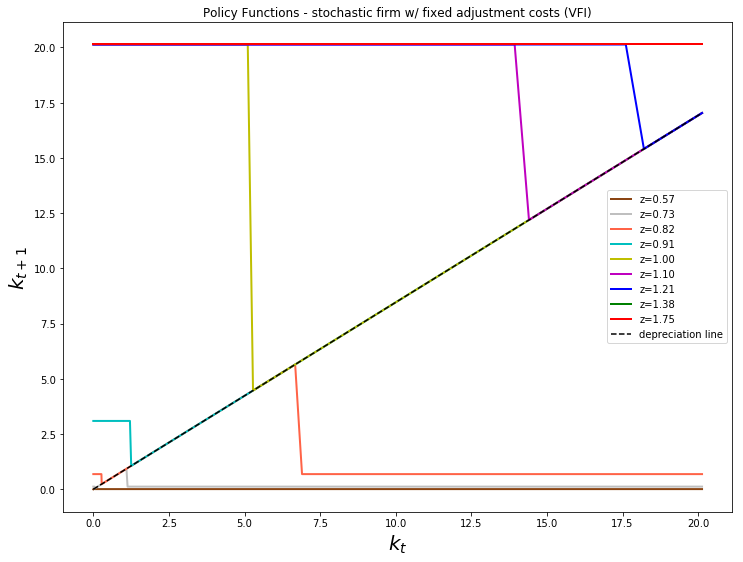

In [64]:
plt.subplots(figsize=(12, 9))
clist = ['#8B4513', '0.75', '#FF6347', 'c', 'y', 'm', 'b', 'g', 'r']
for k in range(sizez):
    lb = 'z='+format(z_grid[k],'.2f')
    plt.plot(k_grid, PF2[:,k], c=clist[k], lw=2, label=lb)
plt.plot(k_grid, (1 - delta) * k_grid, c='k', ls='--', label='depreciation line')
plt.xlabel(r'$k_t$', fontsize=20)
plt.ylabel(r'$k_{t + 1}$', fontsize=20)
plt.title('Policy Functions - stochastic firm w/ fixed adjustment costs (VFI)')
plt.legend()
plt.show()

This makes sense, since a policy function that follows the depreciation line indicates that the agent is choosing not to invest. The steep lines connecting horizontal lines to the depreciation line represent critical points where the agent chooses to stop or start investing.

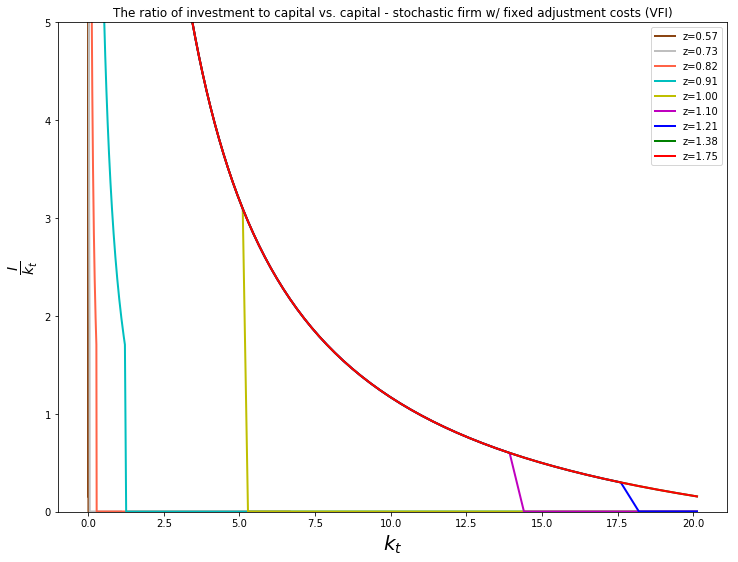

In [65]:
plt.subplots(figsize=(12, 9))
clist = ['#8B4513', '0.75', '#FF6347', 'c', 'y', 'm', 'b', 'g', 'r']
for k in range(sizez):
    lb = 'z='+format(z_grid[k],'.2f')
    plt.plot(k_grid, (PF2[:,k] - (1 - delta) * k_grid) / k_grid, c=clist[k], lw=2, label=lb)
plt.ylim(0, 5)
plt.xlabel(r'$k_t$', fontsize=20)
plt.ylabel(r'$\frac{I}{k_t}$', fontsize=20)
plt.title('The ratio of investment to capital vs. capital - stochastic firm w/ fixed adjustment costs (VFI)')
plt.legend(loc=1)
plt.show()

 My plot for $\frac{I}{k}$ vs. $z$ was not very insightful, so I omitted it.

# Exercise 3 #

In [51]:
@jit
def c1(k_prime, k):
    return (psi1 * (k_prime + k * (delta - 1))) / k

@jit
def E_pi2(k_prime, z_index):
    return np.sum(prod(pi[z_index, :], alpha_k * ((alpha_l / w) ** (alpha_l / (1 - alpha_l))) * (z_grid ** (1 / (1 - alpha_l))) * (k_prime ** ((alpha_k / (1 - alpha_l)) - 1))))

@jit
def c2(k_double_prime, k_prime):
    return -(psi1 * (k_double_prime + (delta - 1) * k_prime) * (k_double_prime + (1 - delta) * k_prime)) / (2 * (k_prime ** 2))

def get_PF3(PF3):
    PF3_next = np.empty((sizek, sizez))
    for i in range(sizek):
        for k in range(sizez):
            def objective(k_prime):
                return 1 + c1(k_prime, k_grid[i]) - betafirm * (E_pi2(k_prime, k) + (1 - delta) - c2(interp(k_prime, k_grid, sizek, PF3[:,k]), k_prime))
            PF3_next[i, k] = brentq(objective, 1e-10, 100)
    return PF3_next

PF3 = np.zeros((sizek, sizez))

PF3dist = 7.0 #7.0 is a good number.

while PF3dist > PF3tol:
    TPF3 = PF3.copy()
    PF3 = get_PF3(TPF3)
    PF3dist = (np.absolute(PF3 - TPF3)).max()

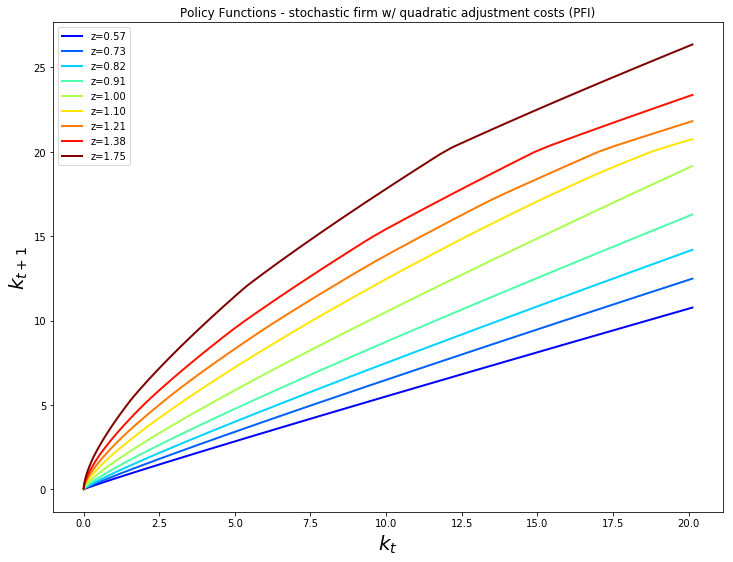

In [53]:
plt.subplots(figsize=(12, 9))
for k in range(sizez):
    lb = 'z='+format(z_grid[k],'.2f')
    plt.plot(k_grid, PF3[:,k], color=plt.cm.jet((k+1)/sizez), lw=2, label=lb)
plt.xlabel(r'$k_t$', fontsize=20)
plt.ylabel(r'$k_{t + 1}$', fontsize=20)
plt.title('Policy Functions - stochastic firm w/ quadratic adjustment costs (PFI)')
plt.legend(loc='best')
plt.show()

In [56]:
V3 = np.zeros((sizek, sizez))  # initial guess at value function
VFiter = 1
VFdist = 7.0

In [59]:
# firm cash flow, e3
e3_grid = np.zeros((sizek, sizez))
for i in range(sizek):  # loop over k
    for k in range(sizez):  # loop over z
        e3_grid[i, k] = (op_grid[i, k] - PF3[i, k] + ((1 - delta) * k_grid[i]) -
                          ((psi1 / 2) * ((PF3[i, k] - ((1 - delta) * k_grid[i])) ** 2) / k_grid[i]))

@jit(i8(f8, f8[:], i8))
def bisect(x_val, xp, xp_len):
    #finds the index of the value in a list that is
    #closest to the value x_val
    lo = 0
    hi = xp_len
    while lo < hi:
        mid = (lo+hi)//2
        if xp[mid] < x_val: lo = mid+1
        else: hi = mid
    if lo == 0: lo += 1
    elif lo == xp_len: lo -= 1
    elif x_val - xp[lo - 1] < xp[lo] - x_val: lo -= 1
    return lo

@jit(void(i8, i8, f8, f8[:,:], f8[:,:]))
def forloop3(sizek, sizez, betafirm, pi, V):
    for i in range(sizek):  # loop over k
        for k in range(sizez):  # loop over z
            V3[i, k] = e3_grid[i, k] + betafirm * np.sum(prod(pi[k, :], V3[bisect(PF3[i, k], k_grid, sizek), :]))

VFiter = 1
while VFdist > VFtol and VFiter < VFmaxiter:
    TV3 = V3.copy()
    forloop3(sizek, sizez, betafirm, pi, V3)
    VFdist = (np.absolute(V3 - TV3)).max()  # check distance between value
    # function for this iteration and value function from past iteration
    VFiter += 1

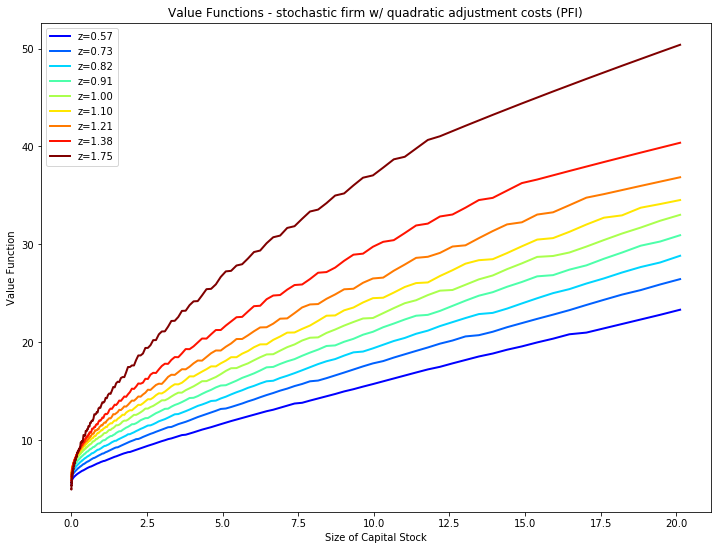

In [58]:
plt.subplots(figsize=(12, 9))
for k in range(sizez):
    lb = 'z='+format(z_grid[k],'.2f')
    plt.plot(k_grid, V3[:,k], color=plt.cm.jet((k+1)/sizez),lw=2,label=lb)
plt.xlabel('Size of Capital Stock')
plt.ylabel('Value Function')
plt.title('Value Functions - stochastic firm w/ quadratic adjustment costs (PFI)')
plt.legend(loc='best')
plt.show()

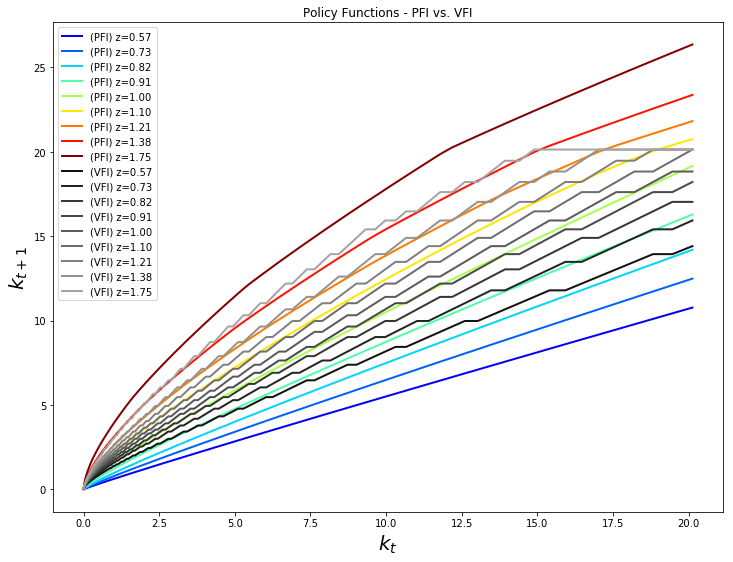

In [62]:
plt.subplots(figsize=(12, 9))
for k in range(sizez):
    lb = '(PFI) z='+format(z_grid[k],'.2f')
    plt.plot(k_grid, PF3[:,k], color=plt.cm.jet((k+1)/sizez), lw=2, label=lb)
for k in range(sizez):
    lb = '(VFI) z='+format(z_grid[k],'.2f')
    plt.plot(k_grid, PF1[:,k], color=plt.cm.gray((k+1)/(sizez+5)),lw=2,label=lb)
plt.xlabel(r'$k_t$', fontsize=20)
plt.ylabel(r'$k_{t + 1}$', fontsize=20)
plt.title('Policy Functions - PFI vs. VFI')
plt.legend(loc='best')
plt.legend()
plt.show()

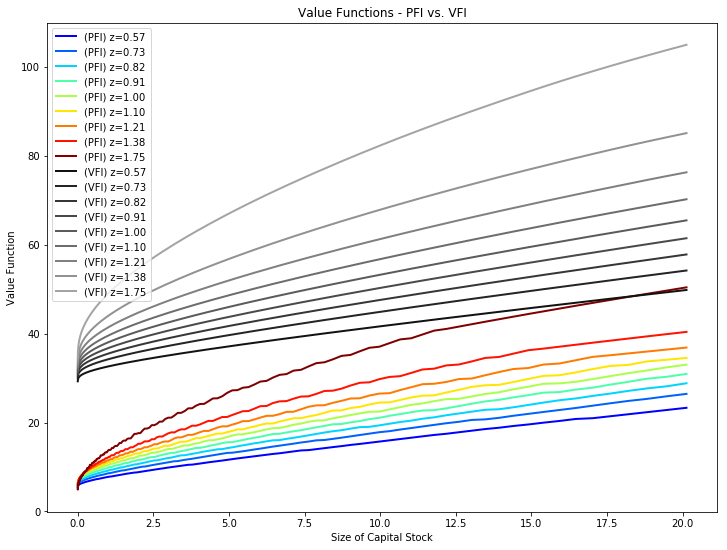

In [61]:
plt.subplots(figsize=(12, 9))
for k in range(sizez):
    lb = '(PFI) z='+format(z_grid[k],'.2f')
    plt.plot(k_grid, V3[:,k], color=plt.cm.jet((k+1)/sizez),lw=2,label=lb)
for k in range(sizez):
    lb = '(VFI) z='+format(z_grid[k],'.2f')
    plt.plot(k_grid, V1[:,k], color=plt.cm.gray((k+1)/(sizez + 5)),lw=2,label=lb)
plt.xlabel('Size of Capital Stock')
plt.ylabel('Value Function')
plt.title('Value Functions - PFI vs. VFI')
plt.legend(loc='best')
plt.show()

Clearly, the PFI method is better at finding policy functions, and the VFI method is better at finding value functions, as demonstrated by the smoothness / bumpiness of the above graphs. Note that there is a discrepancy in scaling and stretching between the two methods. I'm not sure how or why this arises, but it may be due in part to low density grids, or error from linear interpolation and index estimation.